## Import libraries

In [21]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler

has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [22]:
# HYPERPARAMETERS
SEQUENCE_SIZE = 3
dataset_path = "ParkingDataDataset.txt"
split_ratio = 0.7 # 70% training, 30% testing
batch_size = 32

# Regarding training loop
epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')
learning_rate = 0.001

## Load dataset

In [23]:
# read text file into pandas DataFrame
df = pd.read_csv(dataset_path, sep="\t")
df.head(10)

,DateTime,Car ID,Vehicle,VType,Day,ReqT,EntHr,EntMin,ExitHr,ExitMin,...,Tries,DFS,IdleVeh,tFree,z1Free,z2Free,z3Free,z4Free,dReq,Unnamed: 27
0,2022-01-01 08:25:00,936,Student,3,1,406,8,25,8,32,...,1,365,5,93,14,49,8,22,1,NaN
1,2022-01-01 08:25:00,937,Faculty,2,1,1333,8,25,8,47,...,1,354,6,93,14,49,8,22,1,NaN
2,2022-01-01 08:00:00,942,Staff,5,1,8883,8,0,8,0,...,2,672,17,0,0,0,0,0,1,NaN
3,2022-01-01 08:39:00,948,Visitor,1,1,1143,8,39,8,58,...,1,365,12,88,12,46,8,22,1,NaN
4,2022-01-01 08:00:00,983,Student,3,1,7432,8,0,8,0,...,2,672,15,0,0,0,0,0,2,NaN
5,2022-01-01 08:55:00,959,Faculty,2,1,731,8,55,9,8,...,1,354,17,74,3,41,8,22,2,NaN
6,2022-01-01 08:00:00,975,Faculty,2,1,4296,8,0,8,0,...,2,672,12,0,0,0,0,0,2,NaN
7,2022-01-01 09:21:00,977,Student,3,1,95,9,21,9,22,...,1,365,16,60,1,29,8,22,3,NaN
8,2022-01-01 09:16:00,984,Student,3,1,424,9,16,9,23,...,1,354,17,62,1,31,8,22,3,NaN
9,2022-01-01 08:00:00,992,Faculty,2,1,7713,8,0,8,0,...,2,672,14,0,0,0,0,0,6,NaN


In [24]:
df.columns

Index(['DateTime            ', 'Car ID', 'Vehicle', 'VType', 'Day', 'ReqT',
       'EntHr', 'EntMin', 'ExitHr', 'ExitMin', 'TDelay', 'IdleT', 'TBill',
       'Fine', 'PL No.', 'PLZone', 'nFree', 'nFill', 'Tries', 'DFS', 'IdleVeh',
       'tFree', 'z1Free', 'z2Free', 'z3Free', 'z4Free', 'dReq', 'Unnamed: 27'],
      dtype='object')

## Pre-process the dataset

In [25]:
# PREPROCESS THE MAIN DATASET TO GET CLEANED DATA
cleaned_df = df.copy()

# dropping useless columns
cleaned_df.drop('Car ID', inplace=True, axis=1)
cleaned_df.drop('Unnamed: 27', inplace=True, axis=1)
cleaned_df.drop('VType', inplace=True, axis=1)

# dropping useless rows
cleaned_df.drop(cleaned_df[cleaned_df['tFree'] == 0].index, inplace = True)
cleaned_df.drop(cleaned_df[cleaned_df['EntMin'] == 60] .index, inplace = True)

# creating datetime index column
cleaned_df['datetime'] = cleaned_df.iloc[:, 0]
cleaned_df.datetime = pd.to_datetime(cleaned_df.datetime)
cleaned_df.set_index(cleaned_df.datetime)
print('Index Column Created!')

# Sorting the data
cleaned_df = cleaned_df.sort_values(by=['Day', 'EntHr'], ascending=[True, True])

# creating new dataframe for model input
bill_df = cleaned_df.drop(cleaned_df.loc[:, cleaned_df.columns != "TBill"], axis=1)
# bill_df['datetime'] = cleaned_df.datetime
bill_df.set_index(cleaned_df.datetime, inplace=True)
bill_df.head()


Index Column Created!


,TBill
datetime,
2022-01-01 08:25:00,8
2022-01-01 08:25:00,39
2022-01-01 08:39:00,48
2022-01-01 08:55:00,21
2022-01-01 08:49:00,52


In [26]:
# aggregate
ts = bill_df['TBill'].resample('H').sum()
ts = ts.to_frame()
ts.head()

,TBill
datetime,
2022-01-01 08:00:00,4818
2022-01-01 09:00:00,4682
2022-01-01 10:00:00,3459
2022-01-01 11:00:00,4458
2022-01-01 12:00:00,4160


<Axes: xlabel='datetime'>

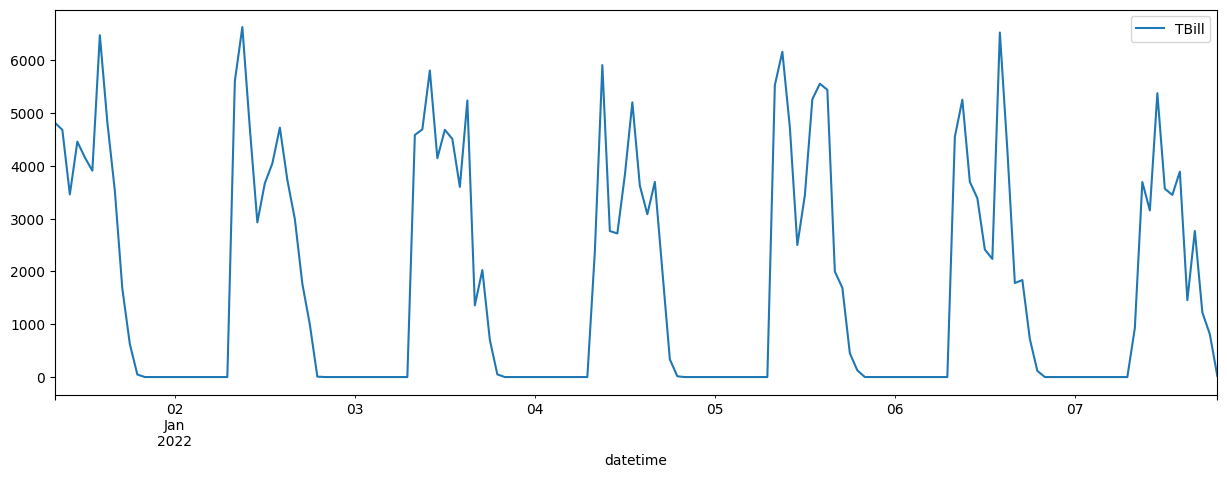

In [27]:
# plotting the aggregated series
ts.plot(figsize=(15, 5))

In [28]:
# SPLIT THE MAIN DATASET INTO TRAIN AND TEST DATASETS
# Determine the split point based on the desired ratio (80% train, 20% test)
split_index = int(split_ratio * len(ts))

# Split the data into training and testing datasets
df_train = ts.iloc[:split_index]
df_test = ts.iloc[split_index:]

In [29]:
# EXTRACT ONLY WHAT'S REQUIRED FROM THE DATASET
bill_train_unscaled = df_train['TBill'].to_numpy().reshape(-1, 1)
bill_test_unscaled = df_test['TBill'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
bill_train = scaler.fit_transform(bill_train_unscaled).flatten().tolist()
bill_test = scaler.transform(bill_test_unscaled).flatten().tolist()

In [30]:
# Sequence Data Preparation
def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, bill_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, bill_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
print(x_train[:3])
print('-----------------')
print(y_train[:3])

tensor([[[1.3506],
         [1.2882],
         [0.7270]],

        [[1.2882],
         [0.7270],
         [1.1854]],

        [[0.7270],
         [1.1854],
         [1.0487]]])
-----------------
tensor([[1.1854],
        [1.0487],
        [0.9331]])


## Positional encoding module

In [32]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Transformer model

In [33]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


The Transformer architecture in PyTorch is governed by crucial configuration choices, among which d_model, nhead, and num_layers hold significant weight. The d_model denotes the dimensionality of the input embeddings and affects the model's capacity to learn intricate representations. While a more substantial d_model can bolster the richness of the model's understanding, it also amplifies the computational demand and can pose overfitting risks if not carefully chosen. Parallelly, the model's gradient flow and initialization are impacted by this choice, though the Transformer's normalization layers often moderate potential issues.

On the other hand, nhead reflects the count of heads in the multi-head attention mechanism. A higher number of heads grants the model the prowess to simultaneously focus on diverse segments of the input, enabling the capture of varied contextual nuances. However, there's a trade-off. Beyond a specific threshold, the computational overhead might outweigh the marginal performance gains. This parallel processing, provided by multiple attention heads, tends to offer more stable and varied gradient information, positively influencing the training dynamics.

Lastly, the num_layers parameter dictates the depth of the Transformer, determining the number of stacked encoder or decoder layers. A deeper model, as a result of increased layers, can discern more complex and hierarchical relationships in data. Still, there's a caveat: after a certain depth, potential performance enhancements may plateau, and the risk of overfitting might escalate. Training deeper models also comes with its set of challenges. Although residual connections and normalization in Transformers alleviate some concerns, a high layer count might necessitate techniques like gradient clipping or learning rate adjustments for stable training.

## Training the model

In [34]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")


Epoch 1/1000, Validation Loss: 2.0276
Epoch 2/1000, Validation Loss: 0.5997
Epoch 3/1000, Validation Loss: 0.6520
Epoch 4/1000, Validation Loss: 0.4142
Epoch 5/1000, Validation Loss: 0.4081
Epoch 6/1000, Validation Loss: 0.4040
Epoch 7/1000, Validation Loss: 0.5384
Epoch 8/1000, Validation Loss: 0.4697
Epoch 9/1000, Validation Loss: 0.4103
Epoch 10/1000, Validation Loss: 0.3734
Epoch 11/1000, Validation Loss: 0.3786
Epoch 12/1000, Validation Loss: 0.3917
Epoch 13/1000, Validation Loss: 0.4091
Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.
Epoch 14/1000, Validation Loss: 0.4326
Early stopping!


In [35]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 1379.2628


## Forecasting

<Axes: xlabel='datetime'>

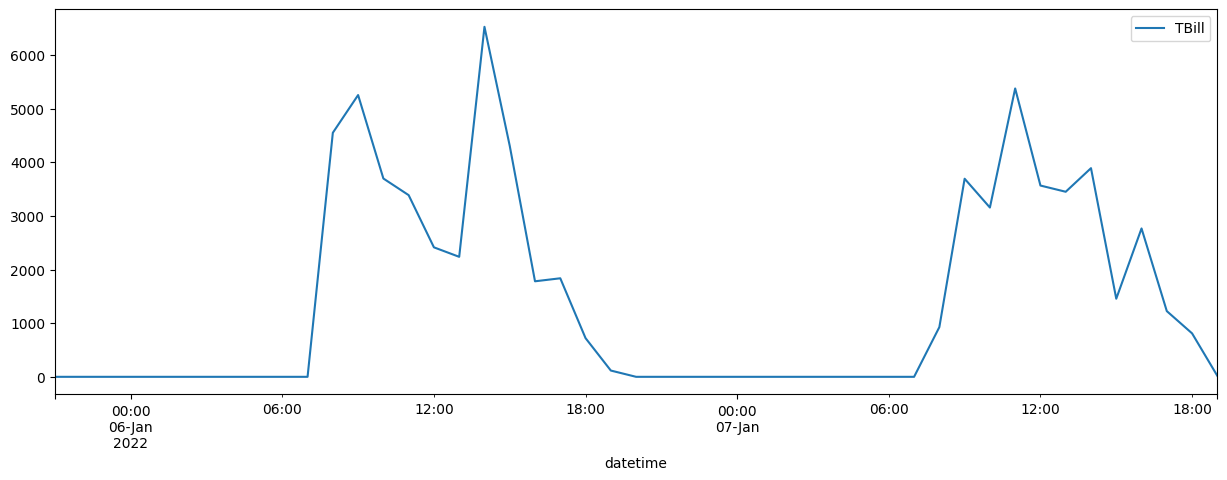

In [36]:
# plotting the aggregated series (ACTUAL TEST DATA)
df_test.plot(figsize=(15, 5))

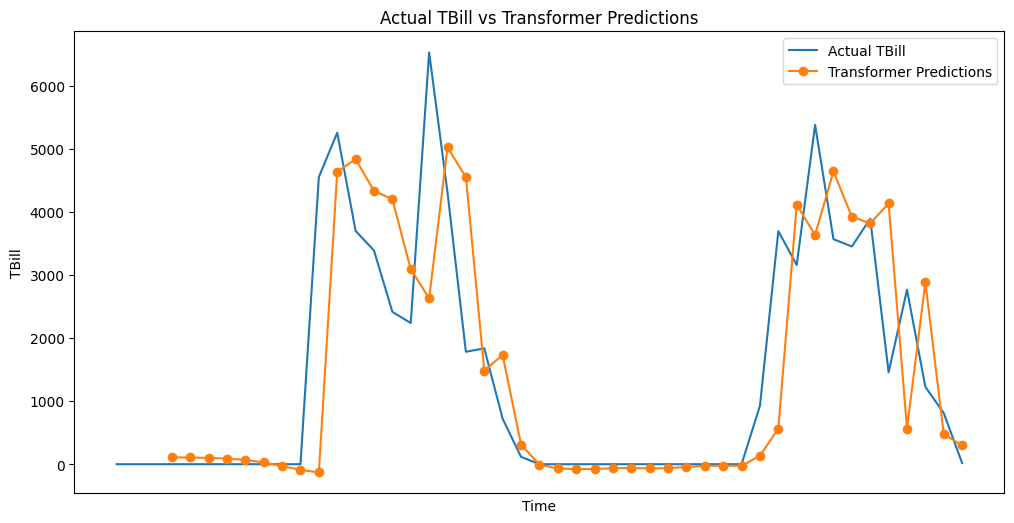

In [37]:
# PLOTTING COMPARISON
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plotting the actual bill data
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, scaler.inverse_transform(np.array(bill_test).reshape(-1, 1)), label='Actual TBill')

# Plotting the Transformer predictions
model.eval()
all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        all_predictions.extend(outputs.squeeze().tolist())

# Convert predictions to original scale
all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

# Plotting Transformer predictions
plt.plot(df_test.index[SEQUENCE_SIZE:], all_predictions, label='Transformer Predictions', marker='o')

# Formatting the plot
plt.title('Actual TBill vs Transformer Predictions')
plt.xlabel('Time')
plt.ylabel('TBill')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Display the plot
plt.show()
